# Memory and Time Profiling for Random Forest Classification of UK Biobank Thyroid Cancer patients

Testing functions on 4000 and 40,000 rows of data to determine estimates of memory and time requirements on the full dataset.

### Notebook Generated using Apocrita OnDemand
- Hudak et al., (2018). Open OnDemand: A web-based client portal for HPC centers. Journal of Open Source Software, 3(25), 622, https://doi.org/10.21105/joss.00622
- This research utilised Queen Mary's Apocrita HPC facility, supported by QMUL Research-IT. http://doi.org/10.5281/zenodo.438045


- Session run using 20 cores with 16GB of RAM each.

# Imports

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import random

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation
from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it 
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder  # Normalisation & Encoding
from imblearn.combine import SMOTETomek  # Sampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



# Jupyter magic commands

# Use %%memit for RAM usage of a cell
%load_ext memory_profiler  

# Functions

In [2]:
# Stopwatch to profile function runtimes 
class Stopwatch:

    # Initiate constructor
    def __init__(self):
        self.start = timer()
        self.end = None
        self.runtime = None

    # Stop stopwatch
    def stop(self):
        self.end = timer()
        self.runtime = self.end - self.start
        return self.runtime


# Produce test/train split from csv/tsv file
def split_tsv(file_path, sep='\t', test_size=0.2):

    df = pd.read_csv(file_path, sep=sep, header=0, index_col=0)
    # y = df['thyroid_cancer']
    # X = df.loc[:, df.columns != 'thyroid_cancer']
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],
                                                        df['thyroid_cancer'],
                                                        test_size=test_size,
                                                        shuffle=True,
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


# Find which columns are categorical and which continuous
def cat_con_cols(df):

    columns = [list(df[i]) for i in df] # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns] # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100 
                         and set([a%1 for a in df[df.columns[i]].dropna()]) == set([0])]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or 
                        set([a%1 for a in df[df.columns[i]].dropna()]) != set([0])]
    
    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con


# Extratrees imputer - equivalent to missforest 
def extra_trees_imputer(dataframe, cat, con):

    cat_imputer = IterativeImputer(estimator=ExtraTreesClassifier(n_estimators=10, 
                                 n_jobs=-1, verbose=0), initial_strategy='most_frequent',
                                 max_iter=5, random_state=random_state, verbose=2)

    imputed_cat = cat_imputer.fit_transform(dataframe[cat])

    con_imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10,
                                 n_jobs=-1, verbose=0), initial_strategy='mean',
                                 max_iter=5, random_state=random_state, verbose=2)


    imputed_con = con_imputer.fit_transform(dataframe[con])

    dataframe.loc[:, cat] = imputed_cat
    dataframe.loc[:, con] = imputed_con

    return dataframe


# Normalised feature scaling
def minmax_scaling(df, continuous_data):

    outdata = df
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[continuous_data])
    outdata[continuous_data] = scaled

    return outdata


# Feature encoding
def feature_encoding(dataframe, ordinal=None, Onehot=None):

    if ordinal != None:

        ordinal_encoder = OrdinalEncoder()
        ordinal_data = ordinal_encoder.fit_transform(dataframe[ordinal])
        dataframe[ordinal] = ordinal_data

    if Onehot != None:
        
        encode_targets = []  # Remove binary columns
        for item in Onehot:
            col = dataframe[item]
            unique = len(set(col))
            if unique > 2:
                encode_targets.append(item)
            
            
        onehot = OneHotEncoder()
        onehot_data = onehot.fit_transform(dataframe[encode_targets]).toarray()  # Create new cols
        one_hot_names = onehot.get_feature_names_out(encode_targets)  # Get new col names
        onehot_df = pd.DataFrame(onehot_data, columns=one_hot_names, index=dataframe.index)  # Create df of new cols
        dataframe = dataframe.drop(axis=1, labels=Onehot)  # Drop original columns
        dataframe = dataframe.join(onehot_df)

    return dataframe


# Over and undersampling with SMOTE-Tomek links
def ST_sampling(X_df, y_df, ratio, random_state):
    
    smt = SMOTETomek(random_state=random_state, sampling_strategy=ratio)
    X_res, y_res = smt.fit_resample(X_df, y_df)
    return X_res, y_res

# Workflow
---

## Random State

In [3]:
random_state = 0

## Test-Train split & some Preprocessing

In [4]:
%%memit
# Split tsv into test and train datasets
split_t = Stopwatch()
X_train, X_test, y_train, y_test = split_tsv('/data/home/bt211037/dissertation/supervised_ML_data.tsv')
print(split_t.stop())

13.118835650966503
peak memory: 5459.43 MiB, increment: 5312.38 MiB


In [5]:
%%memit
# Get the column names of the continuous and nominal data
cct=Stopwatch()
cat, con = cat_con_cols(X_train)
print(cct.stop())

73.30307880695909
peak memory: 6277.31 MiB, increment: 3702.01 MiB


In [ ]:
%%memit
# Convert catagorical cols values from floats to intergers (X_train)
int_t = Stopwatch()
X_train[cat] = X_train[cat].astype('Int64')
print(int_t.stop())

## Imputation

In [12]:
%%memit
# Impute X_train on only 4000 rows
i4_t = Stopwatch()
X_train_i4 = extra_trees_imputer(X_train[0:4000], cat, con)
print(i4_t.stop())

[IterativeImputer] Completing matrix with shape (4000, 161)
[IterativeImputer] Ending imputation round 1/5, elapsed time 5.48
[IterativeImputer] Change: 83.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 2/5, elapsed time 10.79
[IterativeImputer] Change: 79.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 3/5, elapsed time 17.11
[IterativeImputer] Change: 80.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 4/5, elapsed time 22.47
[IterativeImputer] Change: 65.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 5/5, elapsed time 27.82
[IterativeImputer] Change: 81.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Completing matrix with shape (4000, 229)


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Ending imputation round 1/5, elapsed time 35.72
[IterativeImputer] Change: 608861.2456122481, scaled tolerance: 9737.515 
[IterativeImputer] Ending imputation round 2/5, elapsed time 70.73
[IterativeImputer] Change: 938744.396811, scaled tolerance: 9737.515 
[IterativeImputer] Ending imputation round 3/5, elapsed time 107.06
[IterativeImputer] Change: 1478830.87587, scaled tolerance: 9737.515 
[IterativeImputer] Ending imputation round 4/5, elapsed time 141.99
[IterativeImputer] Change: 1520498.3863679997, scaled tolerance: 9737.515 
[IterativeImputer] Ending imputation round 5/5, elapsed time 176.99
[IterativeImputer] Change: 990506.2282860001, scaled tolerance: 9737.515 


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/tmp/2512280.1.short.q/ipykernel_195327/4229399147.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, cat] = imputed_cat
/tmp/2512280.1.short.q/ipykernel_195327/4229399147.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, con] = imputed_con


205.39376906096004
peak memory: 14980.94 MiB, increment: 7173.49 MiB


In [13]:
%%memit
# Impute X_train on 40,000 rows
i40_t = Stopwatch()
X_train_i40 = extra_trees_imputer(X_train[0:40000], cat, con)
print(i40_t.stop())

[IterativeImputer] Completing matrix with shape (40000, 161)
[IterativeImputer] Ending imputation round 1/5, elapsed time 31.15
[IterativeImputer] Change: 122.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 2/5, elapsed time 61.73
[IterativeImputer] Change: 121.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 3/5, elapsed time 92.58
[IterativeImputer] Change: 103.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 4/5, elapsed time 122.31
[IterativeImputer] Change: 110.0, scaled tolerance: 5.1000000000000005 
[IterativeImputer] Ending imputation round 5/5, elapsed time 152.90
[IterativeImputer] Change: 98.0, scaled tolerance: 5.1000000000000005 


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Completing matrix with shape (40000, 229)
[IterativeImputer] Ending imputation round 1/5, elapsed time 416.93
[IterativeImputer] Change: 654307.2742533924, scaled tolerance: 9998.165 
[IterativeImputer] Ending imputation round 2/5, elapsed time 794.43
[IterativeImputer] Change: 991796.4984155999, scaled tolerance: 9998.165 
[IterativeImputer] Ending imputation round 3/5, elapsed time 1171.79
[IterativeImputer] Change: 1409178.6689358002, scaled tolerance: 9998.165 
[IterativeImputer] Ending imputation round 4/5, elapsed time 1547.66
[IterativeImputer] Change: 1146802.7016222002, scaled tolerance: 9998.165 
[IterativeImputer] Ending imputation round 5/5, elapsed time 1925.48
[IterativeImputer] Change: 1071294.0970229, scaled tolerance: 9998.165 


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/tmp/2512280.1.short.q/ipykernel_195327/4229399147.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, cat] = imputed_cat
/tmp/2512280.1.short.q/ipykernel_195327/4229399147.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, con] = imputed_con


2081.87117078295
peak memory: 81369.41 MiB, increment: 69316.90 MiB


In [14]:
# Save imputed test dataframes (only 40,000 rows)
X_train_i4.to_csv('/data/home/bt211037/dissertation/X_train_i4.tsv', sep='\t')
X_train_i40.to_csv('/data/home/bt211037/dissertation/X_train_i40.tsv', sep='\t')

## Feature Scaling

(If needed)

In [ ]:
# Read in imputed files (due to Apocrita jupyter time constraints)
X_train_i4 = pd.read_csv('/data/home/bt211037/dissertation/X_train_i4.tsv', sep='\t', header=0, index_col=0)
X_train_i40 = pd.read_csv('/data/home/bt211037/dissertation/X_train_i40.tsv', sep='\t', header=0, index_col=0)

In [ ]:
%%memit
# Carry out feature scaling - in this case normalisation
norm_X_train_i4 = minmax_scaling(X_train_i4, con)
norm_X_train_i40 = minmax_scaling(X_train_i40, con)

## Feature encoding 

(If needed)

- Ordinal data in this dataset has already been encoded so only one hot encoding is required 

In [ ]:
# List of features/column names which require encoding 
one_hot = ['Weight method|x21_0_0', 'Spirometry method|x23_0_0', 'Sex|x31_0_0', 
           'UK Biobank assessment centre|x54_0_0', 'Birth weight known|x120_0_0', 
           'Type of accommodation lived in|x670_0_0',
           'Own or rent accommodation lived in|x680_0_0', 'Drive faster than motorway speed limit|x1100_0_0',
           'Usual side of head for mobile phone use|x1150_0_0', 'Usual side of head for mobile phone use|x1150_0_0',
           'Morning/evening person (chronotype)|x1180_0_0', 'Nap during day|x1190_0_0', 'Snoring|x1210_0_0',
           'Daytime dozing / sleeping (narcolepsy)|x1220_0_0', 'Current tobacco smoking|x1239_0_0',
           'Past tobacco smoking|x1249_0_0', 'Major dietary changes in the last 5 years|x1538_0_0',
           'Variation in diet|x1548_0_0',  'Alcohol usually taken with meals|x1618_0_0',
           'Alcohol intake versus 10 years previously|x1628_0_0', 'Skin colour|x1717_0_0', 
           'Ease of skin tanning|x1727_0_0', 'Hair colour (natural before greying)|x1747_0_0',
           'Facial ageing|x1757_0_0', 'Father still alive|x1797_0_0', 'Mother still alive|x1835_0_0', 
           'Mood swings|x1920_0_0', 'Miserableness|x1930_0_0', 'Irritability|x1940_0_0', 
           'Sensitivity / hurt feelings|x1950_0_0', 'Fed-up feelings|x1960_0_0', 'Nervous feelings|x1970_0_0',
           'Worrier / anxious feelings|x1980_0_0', "Tense / 'highly strung'|x1990_0_0",
           'Worry too long after embarrassment|x2000_0_0', "Suffer from 'nerves'|x2010_0_0",
           'Loneliness isolation|x2020_0_0', 'Guilty feelings|x2030_0_0', 'Risk taking|x2040_0_0',
           'Seen doctor (GP) for nerves anxiety tension or depression|x2090_0_0',
           'Seen a psychiatrist for nerves anxiety tension or depression|x2100_0_0',
           'Able to confide|x2110_0_0',
           'Answered sexual history questions|x2129_0_0',
           'Ever had same-sex intercourse|x2159_0_0', 'Long-standing illness disability or infirmity|x2188_0_0',
           'Wears glasses or contact lenses|x2207_0_0', 'Other eye problems|x2227_0_0',
           'Plays computer games|x2237_0_0', 'Hearing difficulty/problems|x2247_0_0',
           'Hearing difficulty/problems with background noise|x2257_0_0', 'Use of sun/uv protection|x2267_0_0',
           'Weight change compared with 1 year ago|x2306_0_0',
           'Wheeze or whistling in the chest in last year|x2316_0_0',
           'Chest pain or discomfort|x2335_0_0',
           'Ever had bowel cancer screening|x2345_0_0',
           'Diabetes diagnosed by doctor|x2443_0_0',
           'Cancer diagnosed by doctor|x2453_0_0',
           'Fractured/broken bones in last 5 years|x2463_0_0',
           'Other serious medical condition/disability diagnosed by doctor|x2473_0_0',
           'Taking other prescription medications|x2492_0_0',
           'Pace-maker|x3079_0_0', 'Contra-indications for spirometry|x3088_0_0', 
           'Caffeine drink within last hour|x3089_0_0', 'Used an inhaler for chest within last hour|x3090_0_0',
           'Method of measuring blood pressure|x4081_0_0', 'Qualifications|x6138_0_0',
           'Gas or solid-fuel cooking/heating|x6139_0_0', 
           'How are people in household related to participant|x6141_0_0',
           'Current employment status|x6142_0_0',
           'Never eat eggs dairy wheat sugar|x6144_0_0',
           'Illness injury bereavement stress in last 2 years|x6145_0_0',
           'Attendance/disability/mobility allowance|x6146_0_0',
           'Mouth/teeth dental problems|x6149_0_0',
           'Medication for pain relief constipation heartburn|x6154_0_0',
           'Vitamin and mineral supplements|x6155_0_0', 'Pain type(s) experienced in last month|x6159_0_0',
           'Leisure/social activities|x6160_0_0',
           'Types of transport used (excluding work)|x6162_0_0',
           'Types of physical activity in last 4 weeks|x6164_0_0',
           'Mineral and other dietary supplements|x6179_0_0',
           'Illnesses of father|x20107_0_0',
           'Illnesses of mother|x20110_0_0',
           'Illnesses of siblings|x20111_0_0',
           'Smoking status|x20116_0_0',
           'Alcohol drinker status|x20117_0_0',
           'Home area population density - urban or rural|x20118_0_0',
           'Ever smoked|x20160_0_0',  'Spirometry QC measure|x20255_0_0', 'Genetic sex|x22001_0_0',
           'Genetic kinship to other participants|x22021_0_0',
           'IPAQ activity group|x22032_0_0', 'Summed days activity|x22033_0_0',
           'Above moderate/vigorous recommendation|x22035_0_0',
           'Above moderate/vigorous/walking recommendation|x22036_0_0',
           'Close to major road|x24014_0_0', 'medication_cbi' ]

In [ ]:
%%memit
ohe_X_train_i4 = feature_encoding(norm_X_train_i4, Onehot=one_hot)

In [ ]:
%%memit
ohe_X_train_i40 = feature_encoding(norm_X_train_i40, Onehot=one_hot)

## Sampling 

In [ ]:
%%memit
# Over/Undersampling - SMOTE-Tomek Links
res_X_train_i40, res_y_train_i40 = ST_sampling(ohe_X_train_i40, y_train[0:40000], 0.2, random_state)

## Feature Selection

In [13]:
%%memit
# Cross validated RFE - RFECV
t = Stopwatch()
estimator = ExtraTreesClassifier(n_jobs=-1)
selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), verbose=0, scoring='accuracy')
selector_info = selector.fit(res_X_train_i40, res_y_train_i40)
print(t.stop())

Fitting estimator with 611 features.
Fitting estimator with 610 features.
Fitting estimator with 609 features.
Fitting estimator with 608 features.
Fitting estimator with 607 features.
Fitting estimator with 606 features.
Fitting estimator with 605 features.
Fitting estimator with 604 features.
Fitting estimator with 603 features.
Fitting estimator with 602 features.
Fitting estimator with 601 features.
Fitting estimator with 600 features.
Fitting estimator with 599 features.
Fitting estimator with 598 features.
Fitting estimator with 597 features.
Fitting estimator with 596 features.
Fitting estimator with 595 features.
Fitting estimator with 594 features.
Fitting estimator with 593 features.
Fitting estimator with 592 features.
Fitting estimator with 591 features.
Fitting estimator with 590 features.
Fitting estimator with 589 features.
Fitting estimator with 588 features.
Fitting estimator with 587 features.
Fitting estimator with 586 features.
Fitting estimator with 585 features.
F

Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
Fitting estimator with 386 features.
Fitting estimator with 385 features.
Fitting estimator with 384 features.
Fitting estimator with 383 features.
Fitting estimator with 382 features.
Fitting estimator with 381 features.
Fitting estimator with 380 features.
Fitting estimator with 379 features.
Fitting estimator with 378 features.
Fitting estimator with 377 features.
Fitting estimator with 376 features.
Fitting estimator with 375 features.
Fitting estimator with 374 features.
Fitting estimator with 373 features.
Fitting estimator with 372 features.
Fitting estimator with 371 features.
Fitting estimator with 370 features.
Fitting estimator with 369 features.
Fitting estimator with 368 features.
Fitting estimator with 367 features.
Fitting estimator with 366 features.
Fitting estimator with 365 features.
Fitting estimator with 364 features.
Fitting estimator with 363 features.
F

Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
F

Fitting estimator with 552 features.
Fitting estimator with 551 features.
Fitting estimator with 550 features.
Fitting estimator with 549 features.
Fitting estimator with 548 features.
Fitting estimator with 547 features.
Fitting estimator with 546 features.
Fitting estimator with 545 features.
Fitting estimator with 544 features.
Fitting estimator with 543 features.
Fitting estimator with 542 features.
Fitting estimator with 541 features.
Fitting estimator with 540 features.
Fitting estimator with 539 features.
Fitting estimator with 538 features.
Fitting estimator with 537 features.
Fitting estimator with 536 features.
Fitting estimator with 535 features.
Fitting estimator with 534 features.
Fitting estimator with 533 features.
Fitting estimator with 532 features.
Fitting estimator with 531 features.
Fitting estimator with 530 features.
Fitting estimator with 529 features.
Fitting estimator with 528 features.
Fitting estimator with 527 features.
Fitting estimator with 526 features.
F

Fitting estimator with 330 features.
Fitting estimator with 329 features.
Fitting estimator with 328 features.
Fitting estimator with 327 features.
Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
F

Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator w

Fitting estimator with 493 features.
Fitting estimator with 492 features.
Fitting estimator with 491 features.
Fitting estimator with 490 features.
Fitting estimator with 489 features.
Fitting estimator with 488 features.
Fitting estimator with 487 features.
Fitting estimator with 486 features.
Fitting estimator with 485 features.
Fitting estimator with 484 features.
Fitting estimator with 483 features.
Fitting estimator with 482 features.
Fitting estimator with 481 features.
Fitting estimator with 480 features.
Fitting estimator with 479 features.
Fitting estimator with 478 features.
Fitting estimator with 477 features.
Fitting estimator with 476 features.
Fitting estimator with 475 features.
Fitting estimator with 474 features.
Fitting estimator with 473 features.
Fitting estimator with 472 features.
Fitting estimator with 471 features.
Fitting estimator with 470 features.
Fitting estimator with 469 features.
Fitting estimator with 468 features.
Fitting estimator with 467 features.
F

Fitting estimator with 271 features.
Fitting estimator with 270 features.
Fitting estimator with 269 features.
Fitting estimator with 268 features.
Fitting estimator with 267 features.
Fitting estimator with 266 features.
Fitting estimator with 265 features.
Fitting estimator with 264 features.
Fitting estimator with 263 features.
Fitting estimator with 262 features.
Fitting estimator with 261 features.
Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
F

Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
F

Fitting estimator with 598 features.
Fitting estimator with 597 features.
Fitting estimator with 596 features.
Fitting estimator with 595 features.
Fitting estimator with 594 features.
Fitting estimator with 593 features.
Fitting estimator with 592 features.
Fitting estimator with 591 features.
Fitting estimator with 590 features.
Fitting estimator with 589 features.
Fitting estimator with 588 features.
Fitting estimator with 587 features.
Fitting estimator with 586 features.
Fitting estimator with 585 features.
Fitting estimator with 584 features.
Fitting estimator with 583 features.
Fitting estimator with 582 features.
Fitting estimator with 581 features.
Fitting estimator with 580 features.
Fitting estimator with 579 features.
Fitting estimator with 578 features.
Fitting estimator with 577 features.
Fitting estimator with 576 features.
Fitting estimator with 575 features.
Fitting estimator with 574 features.
Fitting estimator with 573 features.
Fitting estimator with 572 features.
F

Fitting estimator with 376 features.
Fitting estimator with 375 features.
Fitting estimator with 374 features.
Fitting estimator with 373 features.
Fitting estimator with 372 features.
Fitting estimator with 371 features.
Fitting estimator with 370 features.
Fitting estimator with 369 features.
Fitting estimator with 368 features.
Fitting estimator with 367 features.
Fitting estimator with 366 features.
Fitting estimator with 365 features.
Fitting estimator with 364 features.
Fitting estimator with 363 features.
Fitting estimator with 362 features.
Fitting estimator with 361 features.
Fitting estimator with 360 features.
Fitting estimator with 359 features.
Fitting estimator with 358 features.
Fitting estimator with 357 features.
Fitting estimator with 356 features.
Fitting estimator with 355 features.
Fitting estimator with 354 features.
Fitting estimator with 353 features.
Fitting estimator with 352 features.
Fitting estimator with 351 features.
Fitting estimator with 350 features.
F

Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
F

Fitting estimator with 539 features.
Fitting estimator with 538 features.
Fitting estimator with 537 features.
Fitting estimator with 536 features.
Fitting estimator with 535 features.
Fitting estimator with 534 features.
Fitting estimator with 533 features.
Fitting estimator with 532 features.
Fitting estimator with 531 features.
Fitting estimator with 530 features.
Fitting estimator with 529 features.
Fitting estimator with 528 features.
Fitting estimator with 527 features.
Fitting estimator with 526 features.
Fitting estimator with 525 features.
Fitting estimator with 524 features.
Fitting estimator with 523 features.
Fitting estimator with 522 features.
Fitting estimator with 521 features.
Fitting estimator with 520 features.
Fitting estimator with 519 features.
Fitting estimator with 518 features.
Fitting estimator with 517 features.
Fitting estimator with 516 features.
Fitting estimator with 515 features.
Fitting estimator with 514 features.
Fitting estimator with 513 features.
F

Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.
Fitting estimator with 296 features.
Fitting estimator with 295 features.
Fitting estimator with 294 features.
Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
F

In [14]:
# Num of features selected
print(f'Optimum number of features: {selector_info.n_features_}')

Optimum number of features: 139


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


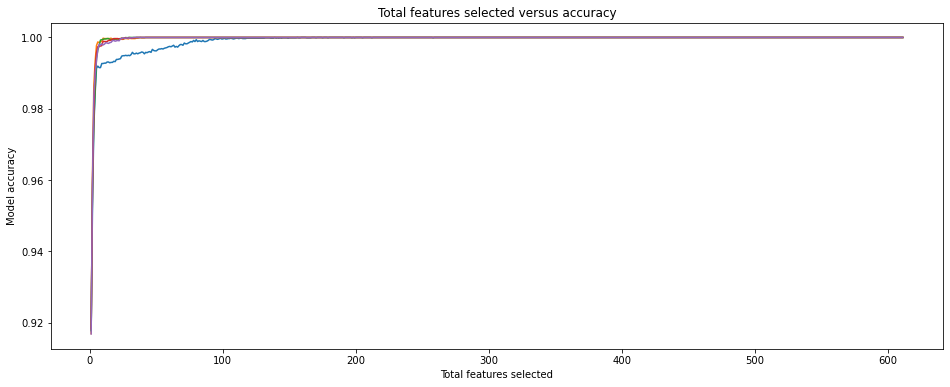

In [15]:
# Plot change in accuracy with num of features
import matplotlib.pyplot as plt
plt.figure( figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(selector_info.grid_scores_) + 1), selector_info.grid_scores_)
plt.show()

In [18]:
# Identifying the features selected by RFE
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

for i in range(res_X_train_i40.shape[1]):
    row = {'feature': list(res_X_train_i40.columns)[i], 'support': selector_info.support_[i], 'ranking': selector_info.ranking_[i]}
    df_features = df_features.concat(row, ignore_index=True)

/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp

/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp/2513692.1.short.q/ipykernel_254168/1054355087.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_features = df_features.append(row, ignore_index=True)
/tmp

,feature,support,ranking
512,Types of physical activity in last 4 weeks|x61...,True,1
380,Alcohol intake versus 10 years previously|x162...,True,1
379,Alcohol intake versus 10 years previously|x162...,True,1
377,Alcohol usually taken with meals|x1618_0_0_1.0,True,1
375,Alcohol usually taken with meals|x1618_0_0_-1.0,True,1
374,Variation in diet|x1548_0_0_3.0,True,1
373,Variation in diet|x1548_0_0_2.0,True,1
372,Variation in diet|x1548_0_0_1.0,True,1
381,Skin colour|x1717_0_0_1.0,True,1
371,Major dietary changes in the last 5 years|x153...,True,1


In [ ]:
df_features.sort_values(by='ranking').head(10)

In [19]:
df_features.to_csv('/data/home/bt211037/dissertation/selected_features.tsv', sep='\t')

# Hyperparameter Tuning

## Cross-Validation

## Model Training

## Model Evaluation

## Model Explainability (SHAP)